In [41]:
import numpy    as np
from numpy.testing._private.utils import decorate_methods
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl
import time

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.ensemble      import AdaBoostRegressor
from sklearn.ensemble      import GradientBoostingRegressor
from xgboost               import XGBRegressor
from lightgbm              import LGBMRegressor
from catboost              import CatBoostRegressor

In [42]:
data = pd.read_csv('london_merged.csv')

np.random.seed(0)

In [43]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [44]:
data.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [46]:
data.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [47]:
data.weather_code.unique()

array([ 3.,  1.,  4.,  7.,  2., 26., 10.])

#### looks like t1 and t2 highly correlated thus unecesary to have them both in the dataset

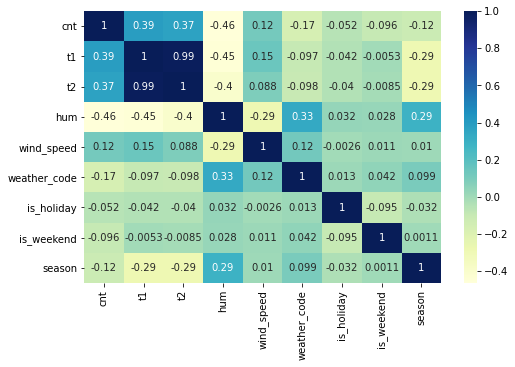

In [48]:
data_num = data.drop(['timestamp'], axis=1)
fig, ax = plt.subplots(figsize=(8,5))  
sb.heatmap(data_num.corr(), cmap='YlGnBu', annot=True) #YlGnBu viridis
plt.show()

#### makes sense to split timestamp into year and month and hour for better analysis and also because bike share data is per hour. Will also drop t1 in following cell as 'real feel' matters more

In [49]:
data['year'] = data['timestamp'].apply(lambda row: row[:4])
data['month'] = data['timestamp'].apply(lambda row: row.split('-')[2][:2] )
data['hour'] = data['timestamp'].apply(lambda row: row.split(':')[0][-2:] )

data.drop(['timestamp'], axis=1, inplace=True)
data.drop(['t1'], axis=1, inplace=True)
data.head()

,cnt,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
0,182,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,04,00
1,138,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,04,01
2,134,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,04,02
3,72,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,04,03
4,47,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,04,04


In [50]:
data.dtypes

cnt               int64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
year             object
month            object
hour             object
dtype: object

In [51]:
def data_enhancement(data):
    
    gen_data = data
    for weather_code in data.weather_code.unique():
        weather_data =  gen_data[gen_data['weather_code'] == weather_code]
        
        hum_cv = weather_data['hum'].std() /weather_data['hum'].mean()
        wind_speed_cv = weather_data['wind_speed'].std() / weather_data['wind_speed'].mean()
        t2_cv = weather_data['t2'].std() / weather_data['t2'].mean()

        for i in gen_data[gen_data['weather_code'] == weather_code].index:
            if np.random.randint(2) == 1:
                gen_data['hum'].values[i] += hum_cv 
            else:
                gen_data['hum'].values[i] -= hum_cv 
                
            if np.random.randint(2) == 1:
                gen_data['wind_speed'].values[i] += wind_speed_cv 
            else:
                gen_data['wind_speed'].values[i] -= wind_speed_cv
                
            if np.random.randint(2) == 1:
                gen_data['t2'].values[i] += t2_cv
            else:
                gen_data['t2'].values[i] -= t2_cv

    return gen_data



In [52]:
data.head(3)

,cnt,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
0,182,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,04,00
1,138,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,04,01
2,134,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,04,02


In [53]:
gen = data_enhancement(data)
gen.head(3)

,cnt,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
0,182,2.507656,92.854291,6.477541,3.0,0.0,1.0,3.0,2015,04,00
1,138,3.135843,93.227560,4.500550,1.0,0.0,1.0,3.0,2015,04,01
2,134,1.864157,96.272440,0.499450,1.0,0.0,1.0,3.0,2015,04,02


#### create season weekend variable

In [54]:
# percentage error went up when i used this
data['season_weekend'] = data['season'] * data['is_weekend']

In [55]:
# generate x and y 

y = data['cnt']
x = data.drop(['cnt'], axis=1)

In [56]:
cat_vars = ['year','month','hour']
#cat_vars = ['year','month','hour', 'weather_code','season_weekend','is_holiday','season']
num_vars = ['t2','hum','wind_speed', 'weather_code','is_weekend','is_holiday','season']

In [57]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)


In [58]:
extra_sample = gen.sample(gen.shape[0] // 4)
x_train = pd.concat([x_train, extra_sample.drop(['cnt'], axis=1 ) ])
y_train = pd.concat([y_train, extra_sample['cnt'] ])

In [59]:
transformer = preprocessing.PowerTransformer()
y_train = transformer.fit_transform(y_train.values.reshape(-1,1))
y_val = transformer.transform(y_val.values.reshape(-1,1))

rang = abs(y_train.max()) + abs(y_train.min())

num_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999)),
])

cat_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', preprocessing.OrdinalEncoder()) # handle_unknown='ignore' ONLY IN VERSION 0.24
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_classifiers = {
  "Decision Tree": DecisionTreeRegressor(),
  "Extra Trees":   ExtraTreesRegressor(n_estimators=100),
  "Random Forest": RandomForestRegressor(n_estimators=100),
  "AdaBoost":      AdaBoostRegressor(n_estimators=100),
  "Skl GBM":       GradientBoostingRegressor(n_estimators=100),
  "XGBoost":       XGBRegressor(n_estimators=100),
  "LightGBM":      LGBMRegressor(n_estimators=100),
  "CatBoost":      CatBoostRegressor(n_estimators=100),
}

In [60]:
tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

results = pd.DataFrame({'Model': [], 'MSE': [], 'MAB': [], " % error": [], 'Time': []})

for model_name, model in tree_classifiers.items():
    
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
        
    pred = model.predict(x_val)
    
    results = results.append({"Model":    model_name,
                              "MSE": metrics.mean_squared_error(y_val, pred),
                              "MAB": metrics.mean_absolute_error(y_val, pred),
                              " % error": metrics.mean_squared_error(y_val, pred) / rang,
                              "Time":     total_time},
                              ignore_index=True)


results_ord = results.sort_values(by=['MSE'], ascending=True, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['MSE', 'MAB'], vmin=0, vmax=100, color='#5fba7d')

C:\Users\rujek\Anaconda3\envs\strive\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rujek\Anaconda3\envs\strive\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rujek\Anaconda3\envs\strive\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rujek\Anaconda3\envs\strive\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed wh

Learning rate set to 0.421295
0:	learn: 0.7062435	total: 19.4ms	remaining: 1.92s
1:	learn: 0.5663076	total: 33.6ms	remaining: 1.65s
2:	learn: 0.4836249	total: 46.6ms	remaining: 1.5s
3:	learn: 0.3932165	total: 59.8ms	remaining: 1.43s
4:	learn: 0.3344811	total: 72.1ms	remaining: 1.37s
5:	learn: 0.3125347	total: 79.4ms	remaining: 1.24s
6:	learn: 0.2994992	total: 87ms	remaining: 1.16s
7:	learn: 0.2885760	total: 91.7ms	remaining: 1.05s
8:	learn: 0.2613717	total: 97.3ms	remaining: 984ms
9:	learn: 0.2531081	total: 102ms	remaining: 917ms
10:	learn: 0.2407616	total: 107ms	remaining: 863ms
11:	learn: 0.2369873	total: 111ms	remaining: 814ms
12:	learn: 0.2342060	total: 116ms	remaining: 777ms
13:	learn: 0.2305901	total: 119ms	remaining: 732ms
14:	learn: 0.2262954	total: 122ms	remaining: 692ms
15:	learn: 0.2237867	total: 125ms	remaining: 657ms
16:	learn: 0.2218050	total: 128ms	remaining: 626ms
17:	learn: 0.2203881	total: 131ms	remaining: 598ms
18:	learn: 0.2120340	total: 134ms	remaining: 572ms
19:	l

,Model,MSE,MAB,% error,Time
1,Extra Trees,0.025742,0.097156,0.004676,4.842632
2,XGBoost,0.027421,0.117778,0.004981,0.506284
3,Random Forest,0.028069,0.111160,0.005099,6.831526
4,CatBoost,0.029731,0.123857,0.005401,0.662584
5,LightGBM,0.030796,0.126106,0.005595,0.168211
6,Decision Tree,0.052744,0.136366,0.009582,0.221662
7,Skl GBM,0.076149,0.200881,0.013834,2.175094
8,AdaBoost,0.205034,0.364838,0.037248,2.136263
